In [1]:
import lmdb
from typing import Union, List, Tuple, Sequence, Dict, Any, Optional, Collection
from torch.utils.data import Dataset
from pathlib import Path
import pickle as pkl

class LMDBDataset(Dataset):
    """Creates a dataset from an lmdb file.
    Args:
        data_file (Union[str, Path]): Path to lmdb file.
        in_memory (bool, optional): Whether to load the full dataset into memory.
            Default: False.
    """

    def __init__(self,
                 data_file: Union[str, Path],
                 in_memory: bool = False):

        data_file = Path(data_file)
        if not data_file.exists():
            raise FileNotFoundError(data_file)

        env = lmdb.open(str(data_file), max_readers=1, readonly=True,
                        lock=False, readahead=False, meminit=False)

        with env.begin(write=False) as txn:
            num_examples = pkl.loads(txn.get(b'num_examples'))

        if in_memory:
            cache = [None] * num_examples
            self._cache = cache

        self._env = env
        self._in_memory = in_memory
        self._num_examples = num_examples

    def __len__(self) -> int:
        return self._num_examples

    def __getitem__(self, index: int):
        if not 0 <= index < self._num_examples:
            raise IndexError(index)

        if self._in_memory and self._cache[index] is not None:
            item = self._cache[index]
        else:
            with self._env.begin(write=False) as txn:
                item = pkl.loads(txn.get(str(index).encode()))
                if 'id' not in item:
                    item['id'] = str(index)
                if self._in_memory:
                    self._cache[index] = item
        return item

In [2]:
def dataset_factory(data_file: Union[str, Path], *args, **kwargs) -> Dataset:
    data_file = Path(data_file)
    if not data_file.exists():
        raise FileNotFoundError(data_file)
    if data_file.suffix == '.lmdb':
        return LMDBDataset(data_file, *args, **kwargs)
    else:
        raise ValueError(f"Unrecognized datafile type {data_file.suffix}")

In [3]:
import torch
import numpy as np
class StabilityDataset(Dataset):

    def __init__(self,
                 data_path: Union[str, Path],
                 split: str,
                 in_memory: bool = False):

        if split not in ('train', 'valid', 'casp12', 'ts115', 'cb513','test'):
            raise ValueError(f"Unrecognized split: {split}. Must be one of "
                             f"['train', 'valid', 'casp12', "
                             f"'ts115', 'cb513']")

        data_path = Path(data_path)
        data_file = f'stability/stability_{split}.lmdb'
        self.data = dataset_factory(data_path / data_file, in_memory)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        item = self.data[index]
        token_ids = item['primary']
        input_mask = np.ones_like(token_ids)

        # pad with -1s because of cls/sep tokens
        labels = np.asarray(item['stability_score'], np.float16)
        output = {'input_ids': token_ids,
                'attention_mask': input_mask,
                'labels': labels}
        return output

In [4]:
data_dir = r'./data'
train_dataset = StabilityDataset(data_dir,'train')
valid_dataset = StabilityDataset(data_dir,'valid')
test_dataset = StabilityDataset(data_dir,'test')

In [5]:
train_sequences=[]
train_labels=[]
for seq in range(train_dataset.__len__()):
    train_sequences.append(train_dataset[seq]['input_ids'])
    train_labels.append(train_dataset[seq]['labels'])

In [6]:
valid_sequences=[]
valid_labels=[]
for seq in range(valid_dataset.__len__()):
    valid_sequences.append(valid_dataset[seq]['input_ids'])
    valid_labels.append(valid_dataset[seq]['labels'])

In [7]:
test_sequences=[]
test_labels=[]
for seq in range(test_dataset.__len__()):
    test_sequences.append(test_dataset[seq]['input_ids'])
    test_labels.append(test_dataset[seq]['labels'])

In [8]:
print(train_labels[0:100])

[array([0.17], dtype=float16), array([-0.18], dtype=float16), array([1.36], dtype=float16), array([0.65], dtype=float16), array([-0.47], dtype=float16), array([-0.15], dtype=float16), array([0.06], dtype=float16), array([-0.9], dtype=float16), array([-0.77], dtype=float16), array([-0.32], dtype=float16), array([0.4], dtype=float16), array([0.03], dtype=float16), array([-1.18], dtype=float16), array([-0.65], dtype=float16), array([-0.42], dtype=float16), array([0.26], dtype=float16), array([-0.24], dtype=float16), array([-0.39], dtype=float16), array([0.2], dtype=float16), array([-0.66], dtype=float16), array([0.17], dtype=float16), array([-0.32], dtype=float16), array([-0.65], dtype=float16), array([-0.12], dtype=float16), array([0.01], dtype=float16), array([-0.5], dtype=float16), array([-0.13], dtype=float16), array([-0.29], dtype=float16), array([-0.15], dtype=float16), array([-0.31], dtype=float16), array([0.06], dtype=float16), array([0.21], dtype=float16), array([-0.07], dtype=fl

In [9]:
# check_point = r"./esm2_t30_150M_UR50D-Stability-mlp-0909/checkpoint-100530"
check_point = r"./esm2_t30_150M_UR50D"

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(check_point)

train_tokenized = tokenizer(train_sequences)
valid_tokenized = tokenizer(valid_sequences)
test_tokenized = tokenizer(test_sequences)

In [11]:
print(train_tokenized.keys())

dict_keys(['input_ids', 'attention_mask'])


In [12]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_tokenized)
valid_dataset = Dataset.from_dict(valid_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset = train_dataset.add_column("labels", train_labels)
valid_dataset = valid_dataset.add_column("labels",valid_labels)
test_dataset = test_dataset.add_column("labels", test_labels)

In [13]:
print(train_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 53614
})


In [14]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoModel
num_labels = 1
model = AutoModelForSequenceClassification.from_pretrained(check_point,problem_type="regression", num_labels=num_labels)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ./esm2_t30_150M_UR50D and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
print(model)

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=640, out_features=640, bias=True)
              (key): Linear(in_features=640, out_features=640, bias=True)
              (value): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((640,), eps=1e-0

In [16]:
# model_name = model_checkpoint.split("/")[-1]
model_name="esm2_t30_150M_UR50D"
batch_size = 32

args = TrainingArguments(
    f"{model_name}-Stability-mlp-0910",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=60,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="mse",
    push_to_hub=False,
    fp16=True,
    fp16_full_eval=True,
    save_total_limit=10,
)

In [17]:
def mse(outputs, labels):
    loss = torch.square(outputs - labels)
    return torch.sum(loss) / len(labels)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)
#     print("predictions:",predictions.size())
#     print(predictions)
#     print("labels:",labels.size())
#     print(labels)
#     torch.save(predictions,"./predictions.pt")
#     torch.save(labels,"./labels.pt")
    # predictions = np.argmax(predictions, axis=1)
    return {"mse":mse(predictions,labels)}

In [18]:
# from evaluate import load
# import numpy as np

# metric = load("mse")

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     # predictions = np.argmax(predictions, axis=1)
#     return metric.compute(predictions=predictions, references=labels)

In [19]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=train_dataset,
#     eval_dataset=valid_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
# )

In [20]:
! export LD_LIBRARY_PATH=/usr/lib/wsl/lib:$LD_LIBRARY_PATH

In [21]:
# trainer.train()

In [22]:
# predictions, labels, _ = trainer.predict(test_dataset)

In [23]:
# torch.save(predictions,"./result/sta-train-mlp-t30/predictions.pt")
# torch.save(labels,"./result/sta-train-mlp-t30/labels.pt")

In [24]:
import torch
predictions = torch.load("./result/sta-train/predictions.pt")
labels = torch.load("./result/sta-train/labels.pt")

In [25]:
import matplotlib.pyplot as plt
import scipy.stats
import sklearn
import pprint
import pandas as pd

In [26]:
def stability_dataset_to_df(in_name):
  dataset = LMDBDataset(in_name)
  df = pd.DataFrame(list(dataset)[:])
  df['stability'] = df.stability_score.apply(lambda x: x[0])
  df['id_str'] = df.id.apply(lambda x: x.decode('utf-8'))
  return df

In [27]:
stability_test_df = stability_dataset_to_df(r'./data/stability/stability_test.lmdb')

In [28]:
parent_to_parent_stability = {}

In [29]:
for parent in set(stability_test_df.parent.values): 
  stabilities = stability_test_df[stability_test_df['id_str']==parent.decode('utf-8') + '.pdb'].stability.values
  if len(stabilities) == 0:
    stabilities = stability_test_df[stability_test_df['id_str']==parent.decode('utf-8')].stability.values
    if len(stabilities) == 0:
      parent_to_parent_stability[parent] = None
    else:
      parent_to_parent_stability[parent] = stabilities[0]
  else:
    parent_to_parent_stability[parent] = stabilities[0]

In [30]:
topology_to_ind = {'HHH': 0, 'HEEH': 1, 'EHEE': 3, 'EEHEE': 4}
def topology_to_index(top):
  """Returns categorical variable corresponding to a topology."""
  
  top = top.decode('utf-8')
  if top in topology_to_ind.keys():
    return topology_to_ind[top]
  else:
    return 2

In [31]:
def create_stability_df(test=False):
  """Processes stability data into a featurized dataframe."""
  
  if test:
    stability_df = stability_dataset_to_df('./data/stability/stability_test.lmdb')
  else:
    stability_df = stability_dataset_to_df('./data/stability/stability_train.lmdb')
  
  # stability_df['one_hot_inds'] = stability_df.primary.apply(lambda x: stability_seq_to_inds(x[:STABILITY_SEQ_LEN]))

  stability_df['parent_stability'] = stability_df.parent.apply(lambda x: parent_to_parent_stability[x])

  stability_df['topology_ind'] = stability_df.topology.apply(lambda x: topology_to_index(x))

  return stability_df


def create_stability_batches(batch_size, epochs=1, test=False, buffer_size=None,
                             seed=0, drop_remainder=False):
  """Creates iterable object of Stability batches."""
  
  if test:
    buffer_size = 1
  
  stability_df = create_stability_df(test=test)
    
  stabilities = stability_df['stability'].values

  stability_batches = create_data_iterator(df=stability_df, input_col='one_hot_inds',
                                           output_col='stability', batch_size=batch_size,
                                           epochs=epochs, buffer_size=buffer_size, 
                                           seed=seed, drop_remainder=drop_remainder)

  return stability_batches, stabilities

In [32]:
def stability_evaluate(predict_fn, title, batch_size=256, 
                       test_data=None, pred_stabilities=None,test_labels=None,
                       clip_min=-999999, clip_max=999999):
  """Computes predicted stabilities and measures performance in spearman correlation."""
  
  
  if test_data is not None:
    test_batches = test_data

  if test_labels is not None:
    test_stabilities = []
    for item in test_labels:
      test_stabilities.append(item)
  
  test_stabilities = np.array(test_stabilities)
  pred_stabilities = np.array(pred_stabilities)
  pred_stabilities = np.clip(pred_stabilities, clip_min, clip_max)
    
  spearmanr = scipy.stats.spearmanr(test_stabilities, pred_stabilities).correlation
  plt.rcParams['font.size'] = 16
  plt.scatter(test_stabilities, pred_stabilities, s=1, alpha=0.5)
  plt.xlabel('True Stability')
  plt.ylabel('Predicted Stability')
  plt.title(title)
  plt.show()
  
  stability_test_df = create_stability_df(test=True)
  stability_test_df['pred_stability'] = pred_stabilities
  stability_test_df['topology_str'] = stability_test_df.topology.apply(lambda x: x.decode('utf-8'))

  parent_to_pred_parent_stability = {}
  for parent in set(stability_test_df.parent.values): 
    pred_parent_stabilities = stability_test_df[stability_test_df['id_str']==parent.decode('utf-8') + '.pdb'].pred_stability.values
    if len(pred_parent_stabilities) == 0:
      pred_parent_stabilities = stability_test_df[stability_test_df['id_str']==parent.decode('utf-8')].pred_stability.values
      if len(pred_parent_stabilities) == 0:
        parent_to_pred_parent_stability[parent] = None
      else:
        parent_to_pred_parent_stability[parent] = pred_parent_stabilities[0]
    else:
      parent_to_pred_parent_stability[parent] = pred_parent_stabilities[0]
  
  stability_test_df['pred_parent_stability'] = stability_test_df.parent.apply(lambda x: parent_to_pred_parent_stability[x])
  
  parent_stabilities = stability_test_df['parent_stability'].values
  pred_parent_stabilities = stability_test_df['pred_parent_stability'].values

  correct_direction = 0
  for test_stability, pred_stability, parent_stability, pred_parent_stability in zip(test_stabilities, pred_stabilities, parent_stabilities, pred_parent_stabilities):
    if parent_stability is not None:
      if (test_stability >= parent_stability and pred_stability >= pred_parent_stability) or (test_stability <= parent_stability and pred_stability <= pred_parent_stability):
        correct_direction += 1
  accuracy = correct_direction / len(np.where(parent_stabilities!=None)[0])
  
  topologies = [('EEHEE', 'BBABB'), ('EHEE', 'BABB'), ('HEEH', 'ABBA'), ('HHH', 'AAA')]
  topology_results = {}
  
  for topology_pair in topologies:
    topology, topology_name = topology_pair
    topology_test_df = stability_test_df[stability_test_df['topology_str']==topology]

    topology_test_stabilities = topology_test_df['stability'].values
    topology_pred_stabilities = topology_test_df['pred_stability'].values
      
    topology_spearmanr = scipy.stats.spearmanr(topology_test_stabilities, topology_pred_stabilities).correlation
    plt.scatter(topology_test_stabilities, topology_pred_stabilities, s=1, alpha=0.5)
    plt.xlabel('True Stability')
    plt.ylabel('Predicted Stability')
    plt.title(title + ' (' + topology_name + ')')
    plt.show()
    
    topology_parent_stabilities = topology_test_df['parent_stability'].values
    topology_pred_parent_stabilities = topology_test_df['pred_parent_stability'].values

    topology_correct_direction = 0
    for test_stability, pred_stability, parent_stability, pred_parent_stability in zip(topology_test_stabilities, topology_pred_stabilities, topology_parent_stabilities, topology_pred_parent_stabilities):
      if parent_stability is not None:
        if (test_stability >= parent_stability and pred_stability >= pred_parent_stability) or (test_stability <= parent_stability and pred_stability <= pred_parent_stability):
          topology_correct_direction += 1
    topology_accuracy = topology_correct_direction / len(np.where(topology_parent_stabilities!=None)[0])
    
    topology_results[topology_name] = (topology_spearmanr, topology_accuracy)

  results = {
      'title': title,
      'spearmanr': round(spearmanr, 3),
      'accuracy': round(accuracy, 3)
  }
  for topology_name in topology_results.keys():
    results[topology_name + '_spearmanr'] = round(topology_results[topology_name][0], 3)
    results[topology_name + '_accuracy'] = round(topology_results[topology_name][1], 3)
  
  pprint.pprint(results)

  return results, pred_stabilities

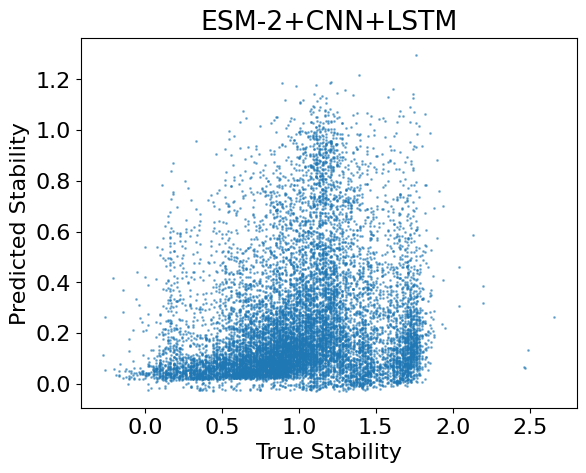

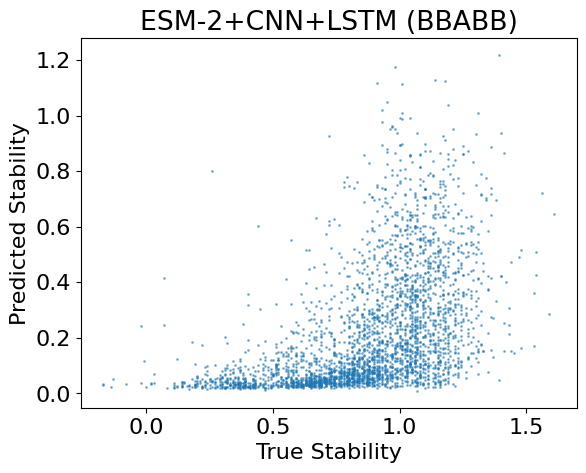

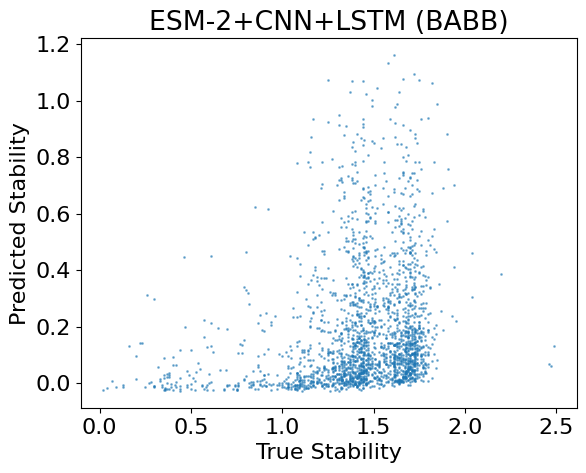

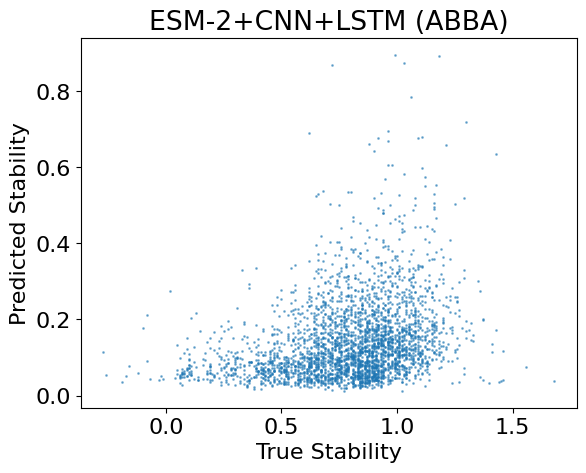

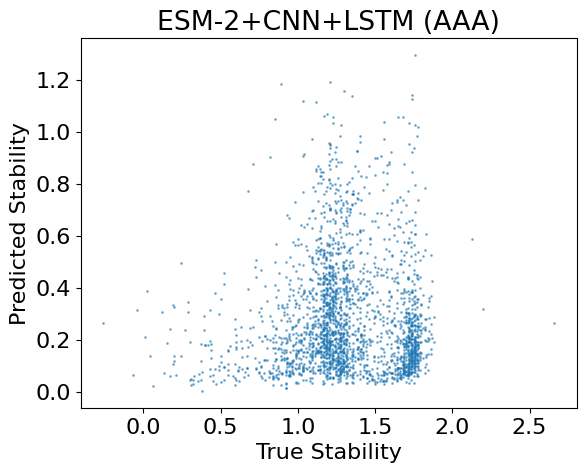

{'AAA_accuracy': 0.62,
 'AAA_spearmanr': 0.015,
 'ABBA_accuracy': 0.734,
 'ABBA_spearmanr': 0.329,
 'BABB_accuracy': 0.72,
 'BABB_spearmanr': 0.313,
 'BBABB_accuracy': 0.692,
 'BBABB_spearmanr': 0.606,
 'accuracy': 0.746,
 'spearmanr': 0.261,
 'title': 'ESM-2+CNN+LSTM'}


In [33]:
stability_linear_model_results, linear_model_pred_stabilities = \
stability_evaluate(predict_fn=None, 
                   title='ESM-2+CNN+LSTM',
                   pred_stabilities=predictions,
                   test_labels=test_labels,
                   clip_min=min(train_labels),
                   clip_max=max(train_labels))